In [ ]:
!pip install gluonnlp 
!pip install sentencepiece
!pip install gast==0.3.3
!pip install mxnet
!pip install transformers

!wget https://www.dropbox.com/s/nzfa9xpzm4edp6o/gpt_ckpt.zip -O gpt_ckpt.zip
!unzip -o gpt_ckpt.zip


     |████████████████████████████████| 348kB 6.7MB/s 
  Created wheel for gluonnlp: filename=gluonnlp-0.10.0-cp36-cp36m-linux_x86_64.whl size=588540 sha256=08f4a27aed9e7fbca48aae370e04b495886c0102112a2ec53d8fee1882e6ca0b
  Stored in directory: /root/.cache/pip/wheels/37/65/52/63032864a0f31a08b9a88569f803b5bafac8abd207fd7f7534
Successfully built gluonnlp
     |████████████████████████████████| 1.1MB 6.7MB/s 
     |████████████████████████████████| 55.0MB 86kB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
     |████████████████████████████████| 1.5MB 5.3MB/s 
     |████████████████████████████████| 2.9MB 32.5MB/s 
     |████████████████████████████████| 890kB 42.7MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=fed3f51d5a8ab2a71cc19e5db06dd1c5dba7b83329cf2af4c46848df0d6dba17
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a5012

In [ ]:
# library import 
import os
import tensorflow as tf
from transformers import TFGPT2Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import gluonnlp as nlp
from gluonnlp.data import SentencepieceTokenizer
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re

# set seed 
SEED_NUM = 1234
tf.random.set_seed(SEED_NUM)
np.random.seed(SEED_NUM)

# 데이터 경로 정의 
DATA_IN_PATH = 'drive/MyDrive/dacon/'
DATA_OUT_PATH = 'drive/MyDrive/dacon/'

# 데이터 로드
train_data = pd.read_csv("/content/drive/MyDrive/dacon/news_train.csv") # train.csv 불러오기
test_data = pd.read_csv("/content/drive/MyDrive/dacon/news_test.csv") # test.csv 불러오기
train_data["id"] = train_data["n_id"].astype(str) + '_' + train_data["ord"].astype(str)
train_data.drop(['n_id', 'ord'],axis = 1) 

In [ ]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

INFO:absl:Entering into master device scope: /job:worker/replica:0/task:0/device:CPU:0


Running on TPU  grpc://10.77.154.202:8470
INFO:tensorflow:Initializing the TPU system: grpc://10.77.154.202:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.77.154.202:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


REPLICAS:  8


In [ ]:
# 파라미터 정의
BATCH_SIZE = 32
NUM_EPOCHS = 3
VALID_SPLIT = 0.1
SENT_MAX_LEN = 39

# 토크나이저 생성 
TOKENIZER_PATH = './gpt_ckpt/gpt2_kor_tokenizer.spiece'

tokenizer = SentencepieceTokenizer(TOKENIZER_PATH)
vocab = nlp.vocab.BERTVocab.from_sentencepiece(TOKENIZER_PATH,
                                               mask_token=None,
                                               sep_token='<unused0>',
                                               cls_token=None,
                                               unknown_token='<unk>',
                                               padding_token='<pad>',
                                               bos_token='<s>',
                                               eos_token='</s>')


# 새 섹션

In [ ]:
# 텍스트 전처리
def clean_text(sent):
    sent_clean = re.sub("[^가-힣ㄱ-ㅎㅏ-ㅣ\\s]", "", sent)
    return sent_clean


train_data_sents = []
train_data_labels = []

for train_sent, train_label in train_data[['content', 'info']].values:
    train_tokenized_text = vocab[tokenizer(clean_text(train_sent))]

    tokens = [vocab[vocab.bos_token]]  
    tokens += pad_sequences([train_tokenized_text], 
                            SENT_MAX_LEN, 
                            value=vocab[vocab.padding_token], 
                            padding='post').tolist()[0] 
    tokens += [vocab[vocab.eos_token]]

    train_data_sents.append(tokens)
    train_data_labels.append(train_label)

train_data_sents = np.array(train_data_sents, dtype=np.int64)
train_data_labels = np.array(train_data_labels, dtype=np.int64)


In [ ]:
class TFGPT2Classifier(tf.keras.Model):
    def __init__(self, dir_path, num_class):
        super(TFGPT2Classifier, self).__init__()
        
        self.gpt2 = TFGPT2Model.from_pretrained(dir_path)
        self.num_class = num_class
        
        self.dropout = tf.keras.layers.Dropout(self.gpt2.config.summary_first_dropout)
        self.classifier = tf.keras.layers.Dense(self.num_class, kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=self.gpt2.config.initializer_range), name="classifier")
        
    def call(self, inputs):
        outputs = self.gpt2(inputs)
        pooled_output = outputs[0][:, -1]

        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        return logits


In [ ]:
BASE_MODEL_PATH = './gpt_ckpt'

# 학습 준비하기(모델, 옵티마이저, 로스, 매트릭, 컴파일)
cls_model = TFGPT2Classifier(dir_path=BASE_MODEL_PATH, num_class=2)
optimizer = tf.keras.optimizers.Adam(learning_rate=6e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
cls_model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

All model checkpoint layers were used when initializing TFGPT2Model.

All the layers of TFGPT2Model were initialized from the model checkpoint at ./gpt_ckpt.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2Model for predictions without further training.


In [ ]:
model_name = "nh_fakenews"

# overfitting을 막기 위한 ealrystop 추가
earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=2)

# 에폭마다 가장 성능이 좋은 모델의 weight를 저장
checkpoint_path = os.path.join(DATA_OUT_PATH, model_name, 'weights.h5')
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)

# Create path if exists
if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))
    
# 학습 시작    
history = cls_model.fit(train_data_sents, train_data_labels, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, validation_split=VALID_SPLIT, callbacks=[earlystop_callback, cp_callback])


drive/MyDrive/dacon/tf2_gpt2_naver_movie -- Folder already exists 

Epoch 1/3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: <cyfunction Socket.send at 0x7f71b692fe58> is not a module, class, method, function, traceback, frame, or code object
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).WARNING:tensorflow:AutoGraph could not transform <bound method Socket.send of <zmq.sugar.socket.Socket object at 0x7f719f0e6660>> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: <cyfunction Socket.send at 0x7f71b692fe58> is not a module, class, method, function, traceback, frame, or code object
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: <cyfunction Socket.send at 0x7f71b692fe58> is not a module, class, method, function, traceback, frame, or code object
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


3340/3340 [==============================] - ETA: 0s - loss: 0.1497 - accuracy: 0.9346

The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


3340/3340 [==============================] - 6597s 2s/step - loss: 0.1497 - accuracy: 0.9346 - val_loss: 0.0422 - val_accuracy: 0.9808

Epoch 00001: val_accuracy improved from -inf to 0.98080, saving model to drive/MyDrive/dacon/tf2_gpt2_naver_movie/weights.h5
Epoch 2/3
3340/3340 [==============================] - 6573s 2s/step - loss: 0.0365 - accuracy: 0.9869 - val_loss: 0.0411 - val_accuracy: 0.9875

Epoch 00002: val_accuracy improved from 0.98080 to 0.98754, saving model to drive/MyDrive/dacon/tf2_gpt2_naver_movie/weights.h5
Epoch 3/3
3340/3340 [==============================] - 6582s 2s/step - loss: 0.0216 - accuracy: 0.9927 - val_loss: 0.0438 - val_accuracy: 0.9875

Epoch 00003: val_accuracy did not improve from 0.98754


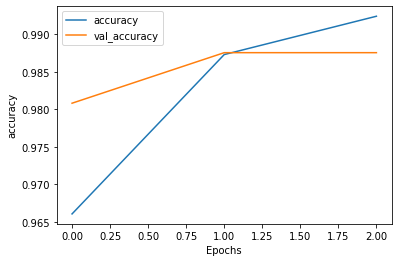

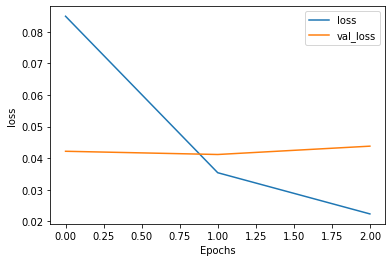

In [ ]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')


# 새 섹션

In [ ]:
test_data_sents = []
test_data_labels = []
test_data['info']=2
for test_sent, test_label in test_data[['content','info']].values:
    test_tokenized_text = vocab[tokenizer(clean_text(test_sent))]

    tokens = [vocab[vocab.bos_token]]  
    tokens += pad_sequences([test_tokenized_text], 
                            SENT_MAX_LEN, 
                            value=vocab[vocab.padding_token], 
                            padding='post').tolist()[0] 
    tokens += [vocab[vocab.eos_token]]

    test_data_sents.append(tokens)
    test_data_labels.append(test_label)

test_data_sents = np.array(test_data_sents, dtype=np.int64)
test_data_labels = np.array(test_data_labels, dtype=np.int64)
print("num sents, labels {}, {}".format(len(test_data_sents), len(test_data_labels)))


num sents, labels 142565, 142565


In [ ]:
# 최종 모델 웨이트 불러오기
cls_model.load_weights(checkpoint_path)

# 모델 평가
results = cls_model.evaluate(test_data_sents, test_data_labels, batch_size=1024)
print("test loss, test acc: ", results)


In [ ]:
cls_model.load_weights(checkpoint_path)
mypredict = cls_model.predict(test_data_sents, batch_size=1024)


The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


In [ ]:
cls_model.summary()

Model: "tfgp_t2classifier_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tfgp_t2model_2 (TFGPT2Model) multiple                  124242432 
_________________________________________________________________
dropout_113 (Dropout)        multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  1538      
Total params: 124,243,970
Trainable params: 124,243,970
Non-trainable params: 0
_________________________________________________________________


# 새 섹션

In [ ]:
logit_result1 = [-1*i[0] for i in mypredict]
prediction1 = tf.round(tf.nn.sigmoid(logit_result1))
submission = pd.read_csv('/content/drive/MyDrive/dacon/sample_submission.csv',index_col= 'id')
submission['info'] = prediction2
submission.to_csv('kogpt2_prediction2.csv',index=True)

# 새 섹션